In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

#### Not processed data

In [2]:
yX = pd.read_csv('yX.csv')

y = yX["y"].copy()
w = yX["w"].copy()

print("yX shape:", yX.shape)
yX.head()

yX shape: (8000, 17)


,w,y,square_meters,bathrooms_number,lift,rooms_number,other_features,total_floors_in_building,car_parking,availability,condominium_fees,year_of_construction,conditions,zone,floor,heating_centralized,energy_efficiency_class
0,1,1125000,135,2,yes,3,optic fiber | security door | balcony | full d...,7,no,available,417,NaN,excellent / refurbished,quadronno - crocetta,2,central,g
1,1,500000,57,1,yes,2,optic fiber | video entryphone | alarm system ...,7,1 in garage/box,available,No condominium fees,2010.0,excellent / refurbished,porta romana - medaglie d'oro,1,central,e
2,1,395000,92,1,yes,3,electric gate | optic fiber | video entryphone...,8,no,available,200,1960.0,excellent / refurbished,gallaratese,1,central,e
3,1,340000,63,1,no,2,optic fiber | video entryphone | security door...,8,no,NaN,208,NaN,excellent / refurbished,martini - insubria,mezzanine,central,f
4,1,199000,38,1,no,1,optic fiber | security door | internal exposur...,4,no,available,80,1930.0,excellent / refurbished,navigli - darsena,1,independent,g


#### Functions for data cleaning and processing

In [3]:
def _safe_str(x) -> str:
    return "" if pd.isna(x) else str(x)

def parse_first_int(x):
    """Estrae il primo intero presente nella stringa. Esempi: '1 floor' -> 1, '3+' -> 3"""
    s = _safe_str(x).strip().lower()
    if not s or s in {"nan", "none"}:
        return np.nan
    m = re.search(r"-?\d+", s)
    return float(m.group()) if m else np.nan

def parse_plus_int(x):
    """Converte '3+' -> 3, '5+' -> 5, altrimenti parse_first_int."""
    s = _safe_str(x).strip().lower()
    if s.endswith("+"):
        s = s[:-1].strip()
    return parse_first_int(s)

def parse_yes_no(x):
    s = _safe_str(x).strip().lower()
    if s in {"yes", "y", "true", "1"}:
        return 1
    if s in {"no", "n", "false", "0"}:
        return 0
    return np.nan

def parse_floor(x):
    """Gestisce 'ground floor', 'mezzanine', 'semi-basement' + numeri."""
    s = _safe_str(x).strip().lower()
    mapping = {
        "ground floor": 0.0,
        "mezzanine": 0.5,
        "semi-basement": -1.0,
    }
    if s in mapping:
        return mapping[s]
    return parse_first_int(s)

def parse_condo_fee(x):
    """Numero oppure 'No condominium fees' -> 0, altrimenti NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.lower() == "no condominium fees":
        return 0.0
    s = s.replace("€", "").strip()
    return float(s) if re.fullmatch(r"\d+(\.\d+)?", s) else np.nan

def parse_car_parking(x):
    """
    car_parking esempi:
      - 'no'
      - '1 in garage/box'
      - '2 in shared parking'
      - '1 in garage/box, 2 in shared parking'
    Output: (garage, shared, total, missing_flag)
    """
    if pd.isna(x):
        return (0, 0, 0, 1)

    s = str(x).strip().lower()
    if s == "no":
        return (0, 0, 0, 0)

    garage = sum(int(n) for n in re.findall(r"(\d+)\s+in\s+garage/box", s))
    shared = sum(int(n) for n in re.findall(r"(\d+)\s+in\s+shared parking", s))
    return (garage, shared, garage + shared, 0)

def parse_availability(x):
    """
    availability esempi:
      - 'available'
      - 'available from 31/12/2024'
    Output: (immediate, year, month, missing_flag)
    """
    if pd.isna(x):
        return (0, 0, 0, 1)

    s = str(x).strip().lower()
    if s == "available":
        return (1, 0, 0, 0)

    m = re.search(r"available\s+from\s+(\d{2})/(\d{2})/(\d{4})", s)
    if m:
        dd, mm, yyyy = map(int, m.groups())
        return (0, yyyy, mm, 0)

    return (0, 0, 0, 1)

def energy_rank(x):
    """
    Ordinale: A migliore.
    a=7, b=6, ..., g=1, missing=0
    """
    s = _safe_str(x).strip().lower()
    if not s or s == ",":
        return 0
    mapping = {"a": 7, "b": 6, "c": 5, "d": 4, "e": 3, "f": 2, "g": 1}
    return mapping.get(s, 0)

In [4]:
def split_other_features(x):
    """
    - Splitta su '|'
    - Corregge concatenazioni note tipo 'pvcdouble exposure' / 'pvcexposure'
    - Corregge casi tipo 'alarm system1 balcony' (manca separatore)
    - Estrae 'num_balconies' da token tipo '1 balcony', '6 balconies'
    Output: (tokens_list, num_balconies)
    """
    if pd.isna(x):
        return ([], 0)

    s = str(x).strip().lower()

    # Fix concatenazioni note (dataset)
    s = s.replace("pvcdouble exposure", "pvc | double exposure")
    s = s.replace("pvcexposure", "pvc | exposure")

    # Fix: manca separatore prima di "1 balcony" (es: "alarm system1 balcony")
    s = re.sub(r"([a-z])(\d+\s+balcon(?:y|ies))", r"\1 | \2", s)

    raw = [p.strip() for p in s.split("|") if p.strip()]

    tokens = []
    max_balconies = 0

    for p in raw:
        m = re.fullmatch(r"(\d+)\s+balcon(?:y|ies)", p)
        if m:
            max_balconies = max(max_balconies, int(m.group(1)))
            tokens.append("balcony")  # normalizzo "1 balcony", "6 balconies" -> "balcony"
        else:
            tokens.append(p)

    # de-dup preservando ordine
    seen = set()
    out = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            out.append(t)

    return (out, max_balconies)

def slugify(s: str) -> str:
    """Rende il nome colonna CSV-safe: lowercase, alfanumerico+underscore."""
    s = re.sub(r"[^a-z0-9]+", "_", s.lower()).strip("_")
    s = re.sub(r"_+", "_", s)
    return s or "feature"

In [6]:
REFERENCE_YEAR = 2024  # usato per building_age; puoi cambiarlo se vuoi

def build_base(df: pd.DataFrame):
    X = pd.DataFrame(index=df.index)

    # numeriche già "pulite"
    X["square_meters"] = pd.to_numeric(df["square_meters"], errors="coerce")
    X["bathrooms_number"] = df["bathrooms_number"].map(parse_plus_int)
    X["rooms_number"] = df["rooms_number"].map(parse_plus_int)

    # booleani / ordinali
    X["lift"] = df["lift"].map(parse_yes_no)

    # floors
    X["total_floors_in_building"] = df["total_floors_in_building"].map(parse_first_int)
    X["floor_num"] = df["floor"].map(parse_floor)

    # parking
    park = df["car_parking"].map(parse_car_parking)
    X["parking_garage"] = park.map(lambda t: t[0])
    X["parking_shared"] = park.map(lambda t: t[1])
    X["parking_total"] = park.map(lambda t: t[2])
    X["parking_missing"] = park.map(lambda t: t[3])

    # availability
    avail = df["availability"].map(parse_availability)
    X["availability_immediate"] = avail.map(lambda t: t[0])
    X["availability_year"] = avail.map(lambda t: t[1])
    X["availability_month"] = avail.map(lambda t: t[2])
    X["availability_missing"] = avail.map(lambda t: t[3])

    # fees
    X["condominium_fees"] = df["condominium_fees"].map(parse_condo_fee)
    X["condominium_fees_missing"] = df["condominium_fees"].isna().astype(int)

    # year of construction + age
    X["year_of_construction"] = pd.to_numeric(df["year_of_construction"], errors="coerce")
    X["year_of_construction_missing"] = X["year_of_construction"].isna().astype(int)
    X["building_age"] = REFERENCE_YEAR - X["year_of_construction"]

    # heating
    h = df["heating_centralized"].astype(str).str.strip().str.lower()
    X["heating_centralized"] = np.select([h.eq("central"), h.eq("independent")], [1, 0], default=np.nan)

    # energy
    X["energy_class_rank"] = df["energy_efficiency_class"].map(energy_rank)
    X["energy_class_missing"] = (df["energy_efficiency_class"].isna() | df["energy_efficiency_class"].astype(str).str.strip().eq(",")).astype(int)

    # other_features: estraggo num_balconies + token list separatamente
    of = df["other_features"].map(split_other_features)
    X["num_balconies"] = of.map(lambda t: t[1])
    tokens = of.map(lambda t: t[0])

    # piccole feature ingegnerizzate (semplici ma utili)
    X["is_top_floor"] = (
        (X["floor_num"].notna())
        & (X["total_floors_in_building"].notna())
        & (X["floor_num"] == X["total_floors_in_building"])
    ).astype(int)

    X["floor_ratio"] = X["floor_num"] / X["total_floors_in_building"]

    return X, tokens


X_train_base, train_tokens = build_base(yX)

# imputazione robusta: mediane dal train (no leakage del test)
medians = X_train_base.median(numeric_only=True)

X_train_base = X_train_base.fillna(medians)

print("Base train:", X_train_base.shape)

Base train: (8000, 25)


In [8]:
mlb = MultiLabelBinarizer()
mlb.fit(train_tokens)

train_of = mlb.transform(train_tokens)

of_cols = [f"of_{slugify(t)}" for t in mlb.classes_]

X_train_of = pd.DataFrame(train_of, columns=of_cols, index=yX.index)

print("Other features train:", X_train_of.shape)

Other features train: (8000, 57)


In [11]:
train_cat = pd.DataFrame({
    "conditions": yX["conditions"].fillna("missing").str.strip().str.lower(),
    "zone": yX["zone"].fillna("missing").str.strip().str.lower(),
})

# compatibilità sklearn: sparse_output (nuovo) vs sparse (vecchio)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(train_cat)

train_cat_ohe = ohe.transform(train_cat)

cat_cols = ohe.get_feature_names_out(["conditions", "zone"])

X_train_cat = pd.DataFrame(train_cat_ohe, columns=cat_cols, index=yX.index)

print("Cat train:", X_train_cat.shape)

Cat train: (8000, 152)


In [14]:
X_train_clean = pd.concat([X_train_base, X_train_of, X_train_cat], axis=1)

print("FINAL train_clean:", X_train_clean.shape)

# salvataggio (senza index, niente colonne 'Unnamed: 0')
X_train_clean.to_csv("X_clean.csv", index=False)
y.to_csv('y_clean.csv')

FINAL train_clean: (8000, 234)


#### Models training and evaluation

In [18]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV

import matplotlib.pyplot as plt

RANDOM_STATE = 42

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [15]:
X = pd.read_csv('X_clean.csv')
y_df = pd.read_csv('y_clean.csv')

print("X shape:", X.shape)
print("y_df shape:", y_df.shape)

display(X.head())
display(y_df.head())

X shape: (8000, 234)
y_df shape: (8000, 2)


,square_meters,bathrooms_number,rooms_number,lift,total_floors_in_building,floor_num,parking_garage,parking_shared,parking_total,parking_missing,availability_immediate,availability_year,availability_month,availability_missing,condominium_fees,condominium_fees_missing,year_of_construction,year_of_construction_missing,building_age,heating_centralized,energy_class_rank,energy_class_missing,num_balconies,is_top_floor,floor_ratio,of_alarm_system,of_attic,of_balcony,of_cellar,of_centralized_tv_system,of_closet,of_disabled_access,of_double_exposure,of_electric_gate,of_exposure_east,of_exposure_east_west,of_exposure_north,of_exposure_north_east,of_exposure_north_east_west,of_exposure_north_south,of_exposure_north_south_east,of_exposure_north_south_east_west,of_exposure_north_south_west,of_exposure_north_west,of_exposure_south,of_exposure_south_east,of_exposure_south_east_west,of_exposure_south_west,of_exposure_west,of_external_exposure,of_fireplace,of_full_day_concierge,of_furnished,of_half_day_concierge,of_hydromassage,of_internal_exposure,of_kitchen,of_only_kitchen_furnished,of_optic_fiber,of_partially_furnished,of_pool,of_private_and_shared_garden,of_private_garden,of_property_land,of_reception,of_security_door,of_shared_garden,of_single_tv_system,of_tavern,of_tennis_court,of_terrace,of_tv_system_with_satellite_dish,of_video_entryphone,of_window_frames_in_double_glass_metal,of_window_frames_in_double_glass_pvc,of_window_frames_in_double_glass_wood,of_window_frames_in_glass_metal,of_window_frames_in_glass_pvc,of_window_frames_in_glass_wood,of_window_frames_in_triple_glass_metal,of_window_frames_in_triple_glass_pvc,of_window_frames_in_triple_glass_wood,conditions_excellent / refurbished,conditions_good condition / liveable,conditions_missing,conditions_new / under construction,conditions_to be refurbished,zone_affori,zone_amendola - buonarroti,zone_arco della pace,zone_arena,zone_argonne - corsica,zone_ascanio sforza,zone_baggio,zone_bande nere,zone_barona,zone_bicocca,zone_bignami - ponale,zone_bisceglie,zone_bocconi,...,zone_farini,zone_figino,zone_frua,zone_gallaratese,zone_gambara,zone_garibaldi - corso como,zone_ghisolfa - mac mahon,zone_giambellino,zone_gorla,zone_gratosoglio,zone_greco - segnano,zone_guastalla,zone_indipendenza,zone_inganni,zone_isola,zone_istria,zone_lambrate,zone_lanza,zone_lodi - brenta,zone_lorenteggio,zone_maggiolina,zone_martini - insubria,zone_melchiorre gioia,zone_missing,zone_missori,zone_molise - cuoco,zone_monte rosa - lotto,zone_monte stella,zone_montenero,zone_morgagni,zone_moscova,zone_muggiano,zone_navigli - darsena,zone_niguarda,zone_ortica,zone_pagano,zone_palestro,zone_paolo sarpi,zone_parco lambro,zone_parco trotter,zone_pasteur,zone_pezzotti - meda,zone_piave - tricolore,zone_piazza napoli,zone_piazzale siena,zone_plebisciti - susa,zone_ponte lambro,zone_ponte nuovo,zone_porta nuova,zone_porta romana - medaglie d'oro,zone_porta venezia,zone_porta vittoria,zone_portello - parco vittoria,zone_prato centenaro,zone_precotto,zone_primaticcio,zone_qt8,zone_quadrilatero della moda,zone_quadronno - crocetta,zone_quartiere adriano,zone_quartiere feltre,zone_quartiere forlanini,zone_quartiere olmi,zone_quarto cagnino,zone_quarto oggiaro,zone_quinto romano,zone_quintosole - chiaravalle,zone_repubblica,zone_ripamonti,zone_rogoredo,zone_roserio,zone_rovereto,zone_rubattino,zone_san babila,zone_san carlo,zone_san siro,zone_san vittore,zone_sant'ambrogio,zone_santa giulia,zone_scala - manzoni,zone_sempione,zone_solari,zone_ticinese,zone_tre castelli - faenza,zone_trenno,zone_tripoli - soderini,zone_turati,zone_turro,zone_udine,zone_vercelli - wagner,zone_via calizzano,zone_via canelli,zone_via fra' cristoforo,zone_vialba,zone_viale ungheria - mecenate,zone_vigentino - fatima,zone_villa san giovanni,zone_vincenzo monti,zone_washington,zone_zara
0,135,2.0,3.0,1.0,7.0,2.0,0,0,0,0,1,0,0,0,417.0,0,1960.0,1,64.0,1.0,1,0,0,0,0.285714,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0

,Unnamed: 0,y
0,0,1125000
1,1,500000
2,2,395000
3,3,340000
4,4,199000


In [19]:
def extract_y_w(y_df: pd.DataFrame):
    """
    Supporta:
    - colonna 'y' (preferita) oppure prima colonna come target
    - colonna 'w' opzionale per sample weights
    """
    col_map = {c.lower().strip(): c for c in y_df.columns}

    y_col = col_map["y"] if "y" in col_map else y_df.columns[0]
    w_col = col_map["w"] if "w" in col_map else None

    y = y_df[y_col].astype(float).values
    w = y_df[w_col].astype(float).values if w_col is not None else None
    return y, w, y_col, w_col

y, w, y_col, w_col = extract_y_w(y_df)

print("Target col:", y_col)
print("Weight col:", w_col)
print("y shape:", y.shape, "w:", None if w is None else w.shape)

Target col: y
Weight col: None
y shape: (8000,) w: None


In [20]:
# Se non ci sono pesi, usiamo array di 1 per coerenza nello split; poi li settiamo a None
w_for_split = w if w is not None else np.ones_like(y)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w_for_split,
    test_size=0.20,
    random_state=RANDOM_STATE
)

if w_col is None:
    w_train, w_test = None, None

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Weights:", None if w_train is None else (w_train.shape, w_test.shape))

Train: (6400, 234) Test: (1600, 234)
Weights: None


In [25]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def eval_regression(y_true, y_pred, sample_weight=None):
    mse = mean_squared_error(y_true, y_pred, sample_weight=sample_weight)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight)
    return {"rmse": rmse, "r2": r2}

In [26]:
results = []
preds_test = {}  # predizioni sul test holdout (per confronto)
models = {}      # per salvare gli oggetti modello

#### Random Forest

In [27]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train, sample_weight=w_train)

y_pred = rf.predict(X_test)
preds_test["RandomForest"] = y_pred
models["RandomForest"] = rf

m = eval_regression(y_test, y_pred, sample_weight=w_test)
results.append({"model": "RandomForest", **m})
print(m)

{'rmse': np.float64(183184.3899194047), 'r2': 0.7949439504770868}


#### Linear regression

In [28]:
lin = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

lin.fit(X_train, y_train, model__sample_weight=w_train)

y_pred = lin.predict(X_test)
preds_test["Linear"] = y_pred
models["Linear"] = lin

m = eval_regression(y_test, y_pred, sample_weight=w_test)
results.append({"model": "Linear", **m})
print(m)


{'rmse': np.float64(173991.38534651694), 'r2': 0.8150087642642154}


#### Lasso (con CV)

In [29]:
lasso = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LassoCV(
        alphas=None,         # griglia automatica
        cv=5,
        random_state=RANDOM_STATE,
        max_iter=20000
    ))
])

lasso.fit(X_train, y_train, model__sample_weight=w_train)

best_alpha = lasso.named_steps["model"].alpha_
print("Best alpha:", best_alpha)

y_pred = lasso.predict(X_test)
preds_test["Lasso"] = y_pred
models["Lasso"] = lasso

m = eval_regression(y_test, y_pred, sample_weight=w_test)
results.append({"model": "Lasso", **m})
print(m)

C:\Users\filip\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Best alpha: 886.6134995490331
{'rmse': np.float64(174034.23539896082), 'r2': 0.8149176349219065}


#### Gradient Boosting

In [30]:
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=RANDOM_STATE
)

gbr.fit(X_train, y_train, sample_weight=w_train)

y_pred = gbr.predict(X_test)
preds_test["GradientBoosting"] = y_pred
models["GradientBoosting"] = gbr

m = eval_regression(y_test, y_pred, sample_weight=w_test)
results.append({"model": "GradientBoosting", **m})
print(m)

{'rmse': np.float64(165986.24093333865), 'r2': 0.8316396419592672}


### Results

In [31]:
results_df = pd.DataFrame(results).sort_values("rmse").reset_index(drop=True)
results_df


,model,rmse,r2
0,GradientBoosting,165986.240933,0.831640
1,Linear,173991.385347,0.815009
2,Lasso,174034.235399,0.814918
3,RandomForest,183184.389919,0.794944


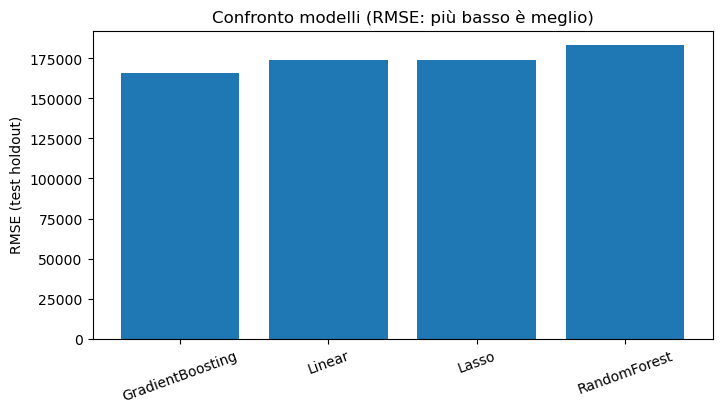

In [32]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["rmse"])
plt.xticks(rotation=20)
plt.ylabel("RMSE (test holdout)")
plt.title("Confronto modelli (RMSE: più basso è meglio)")
plt.show()


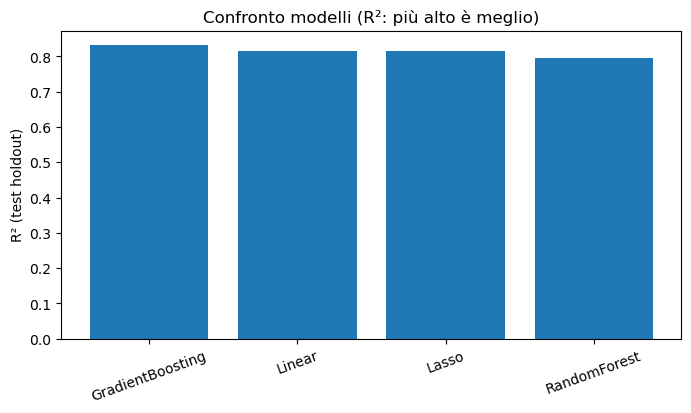

In [33]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["r2"])
plt.xticks(rotation=20)
plt.ylabel("R² (test holdout)")
plt.title("Confronto modelli (R²: più alto è meglio)")
plt.show()


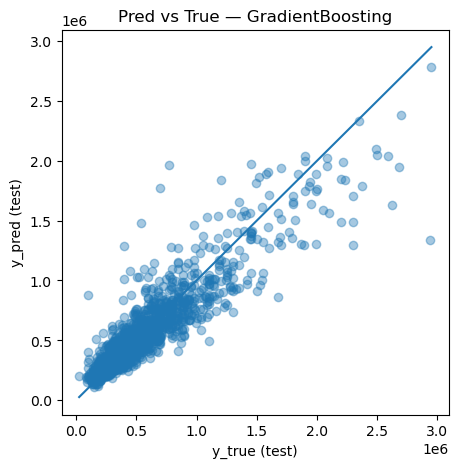

Best model: GradientBoosting


In [34]:
best_model_name = results_df.loc[0, "model"]
y_pred_best = preds_test[best_model_name]

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_best, alpha=0.4)
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (test)")
plt.title(f"Pred vs True — {best_model_name}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

print("Best model:", best_model_name)
